# Workflow Debugging

0.8785714285714286
len(y_predicted) 420


DecisionTreeClassifier(max_depth=5)

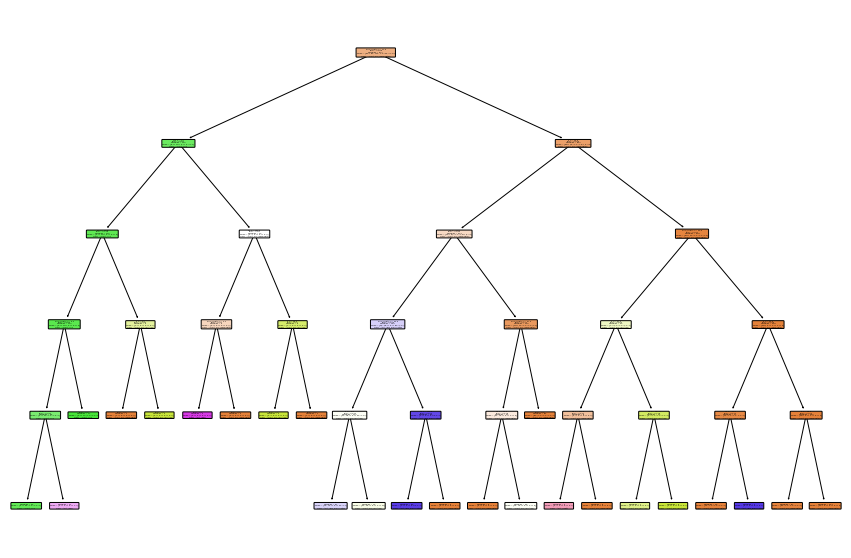

<Figure size 1224x432 with 0 Axes>

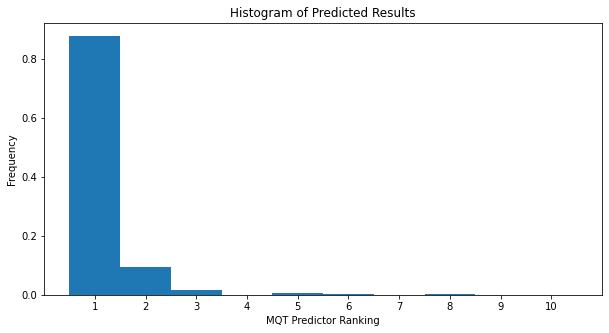

In [3]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


training_data, names_list, scores_list = Predictor.extract_training_data_from_json("json_data_bigger_server.json", True)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#non_zero_indices = []
#for i in range(len(X[0])):
#    if sum(X[:,i]) > 0:
#        non_zero_indices.append(i)
#X = X[:, non_zero_indices]
#openqasm_gates_list = utils.get_openqasm_gates()
#res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
#res.append("num_qubits")
#features = np.sort(np.array(res))
#features = features[non_zero_indices]
#print(features)

scaler = preprocessing.StandardScaler().fit(X)
#X = preprocessing.normalize(X, norm='l2')
#X = scaler.transform(X)

Predictor.train_decision_tree_classifier(X,y, names_list, scores_list)